In [1]:
!pip install scikit-learn==1.3.2 keras-tuner tensorflow  # Ensure versions; TF for NN
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt
import kerastuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0,

2025-12-10 13:46:35.325396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765374395.773933      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765374395.991445      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_20/972368329.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
# Load NN data (PCA-reduced numerical components, scaled)
# Adjust slug if your dataset name differs
train_path = '/kaggle/input/telco-train-test-split-dataset/train_nn.csv'  # Resampled/reduced train
test_path = '/kaggle/input/telco-train-test-split-dataset/test_nn.csv'     # Reduced test

In [3]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [4]:
# Check for NaNs in labels
print("NaNs in y_train:", df_train['Churn'].isna().sum())
print("NaNs in y_test:", df_test['Churn'].isna().sum())

# Drop rows with NaN in Churn (if any)
df_train = df_train.dropna(subset=['Churn'])
df_test = df_test.dropna(subset=['Churn'])

NaNs in y_train: 0
NaNs in y_test: 1148


In [5]:
X_train = df_train.drop('Churn', axis=1)
y_train = df_train['Churn']
X_test = df_test.drop('Churn', axis=1)
y_test = df_test['Churn']

# Ensure y is int (in case read as float)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [6]:
# Check for NaNs in labels after dropping
print("NaNs in y_train:", df_train['Churn'].isna().sum())
print("NaNs in y_test:", df_test['Churn'].isna().sum())

NaNs in y_train: 0
NaNs in y_test: 0


In [7]:
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(X_train.head())  # Verify numerical columns 0-14 (PCs)

Train shape: (8278, 15), Test shape: (261, 15)
          0         1         2         3         4         5         6  \
0 -0.108813 -0.418149  0.961060 -0.681419  0.661299  0.483682  1.353935   
1 -0.350782 -0.841084  0.378889  1.198093 -0.490107  0.582896 -0.752784   
2 -0.955834 -0.223049  2.099968  0.899251 -0.204053  0.457777 -0.257728   
3  0.574153 -0.274793  0.453367  0.234906 -0.199071 -0.564913  0.506081   
4 -1.421389 -1.165797  0.568709  1.038760  0.679527  0.468234 -0.221240   

          7         8         9        10        11        12        13  \
0 -0.327025 -0.372298 -0.770925  0.509539  0.082056 -0.216659 -0.074368   
1  0.087479 -0.530567  0.103014  0.399851  0.012191  0.826560 -0.076605   
2 -0.558649 -0.529306  0.448755 -0.180681  0.426710 -0.270131 -0.290288   
3 -0.603274  1.055994 -0.161335 -0.055088  0.820367 -0.195254  0.288055   
4 -0.071850 -0.478216 -0.532025 -0.129087 -0.029205  0.090753 -0.026735   

         14  
0 -0.352940  
1  0.270426  
2  0.3109

In [8]:
# Hyperparameter Tuning with KerasTuner
def build_nn(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units1', min_value=32, max_value=128, step=32), input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(hp.Int('units2', min_value=16, max_value=64, step=16), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_nn,
    objective='val_accuracy',
    max_trials=10,  # Balance time; increase if needed
    executions_per_trial=1,
    directory='/kaggle/working/tuner_dir',
    project_name='churn_nn_tune'
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)

Trial 10 Complete [00h 00m 17s]
val_accuracy: 0.8182367086410522

Best val_accuracy So Far: 0.9480676054954529
Total elapsed time: 00h 04m 16s


In [9]:
# Best model and hyperparams (FIXED HERE)
best_nn = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best NN Params: units1={best_hyperparams.get('units1')}, units2={best_hyperparams.get('units2')}, lr={best_hyperparams.get('lr')}")

Best NN Params: units1=128, units2=48, lr=0.0033137745378583987


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [10]:
# Retrain on full train with best params (for final fit)
history = best_nn.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)

Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9347 - loss: 0.1563 - val_accuracy: 0.8901 - val_loss: 0.2447
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9390 - loss: 0.1400 - val_accuracy: 0.8986 - val_loss: 0.2794
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9429 - loss: 0.1409 - val_accuracy: 0.9179 - val_loss: 0.2110
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9420 - loss: 0.1354 - val_accuracy: 0.9354 - val_loss: 0.1737
Epoch 5/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9465 - loss: 0.1273 - val_accuracy: 0.8726 - val_loss: 0.2855
Epoch 6/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9427 - loss: 0.1392 - val_accuracy: 0.8774 - val_loss: 0.2867
Epoch 7/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9403 - loss: 0.1393 - val_accuracy: 0.9227 - val_loss: 0.1738
Epoch 8/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9434 - loss: 0.1360 - val_accu

In [11]:
# Predictions on test
y_prob_nn = best_nn.predict(X_test).flatten()
y_pred_nn = (y_prob_nn > 0.5).astype(int)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [12]:
# Evaluation Metrics
metrics_nn = {
    'Accuracy': accuracy_score(y_test, y_pred_nn),
    'Precision': precision_score(y_test, y_pred_nn),
    'Recall': recall_score(y_test, y_pred_nn),
    'F1-Score': f1_score(y_test, y_pred_nn),
    'ROC-AUC': roc_auc_score(y_test, y_prob_nn)
}
print("NN Test Metrics:", metrics_nn)

NN Test Metrics: {'Accuracy': 0.6206896551724138, 'Precision': 0.3108108108108108, 'Recall': 0.323943661971831, 'F1-Score': 0.31724137931034485, 'ROC-AUC': 0.5902149740548555}


In [13]:
# Save metrics table for report
pd.DataFrame(list(metrics_nn.items()), columns=['Metric', 'Value']).to_csv('/kaggle/working/nn_metrics.csv', index=False)

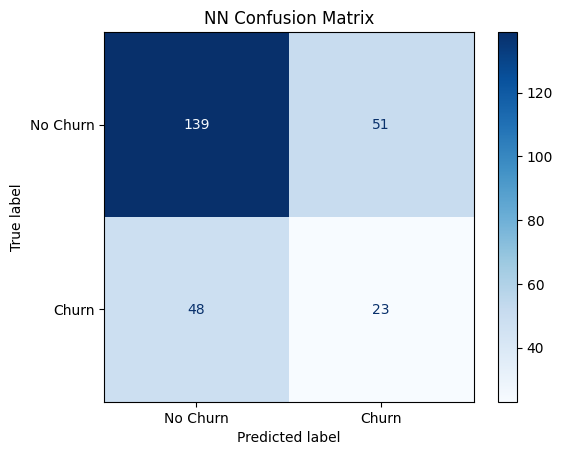

In [14]:
# Visualizations
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nn)
ConfusionMatrixDisplay(cm, display_labels=['No Churn', 'Churn']).plot(cmap='Blues')
plt.title('NN Confusion Matrix')
plt.savefig('/kaggle/working/nn_confusion_matrix.png')
plt.show()

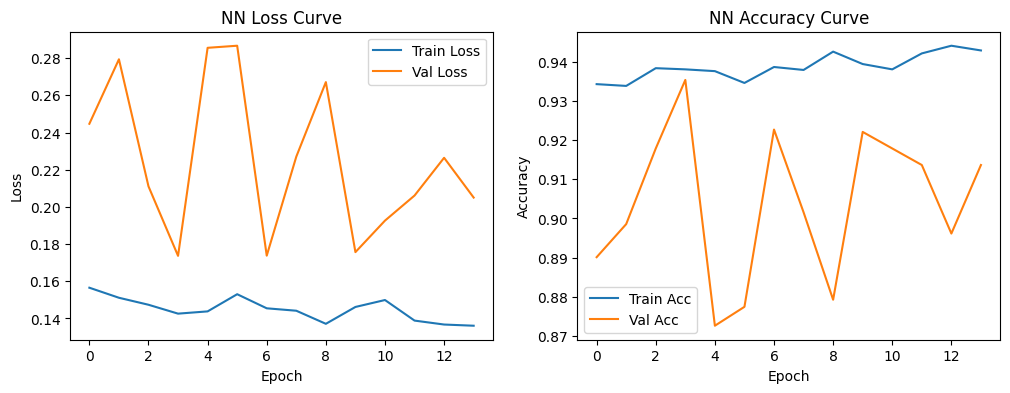

In [15]:
# Training History Plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('NN Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('NN Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/kaggle/working/nn_training_history.png')
plt.show()

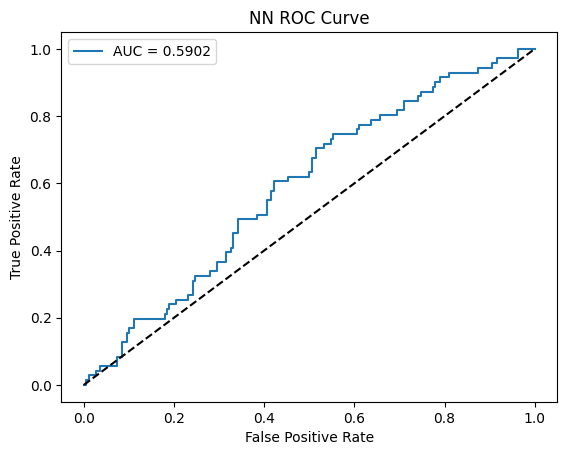

In [16]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_nn)
plt.plot(fpr, tpr, label=f'AUC = {metrics_nn["ROC-AUC"]:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NN ROC Curve')
plt.legend()
plt.savefig('/kaggle/working/nn_roc_curve.png')
plt.show()